CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 80927848.91it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 78506606.50it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20309317.87it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13744970.25it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [ ]:
batch_size = 256

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

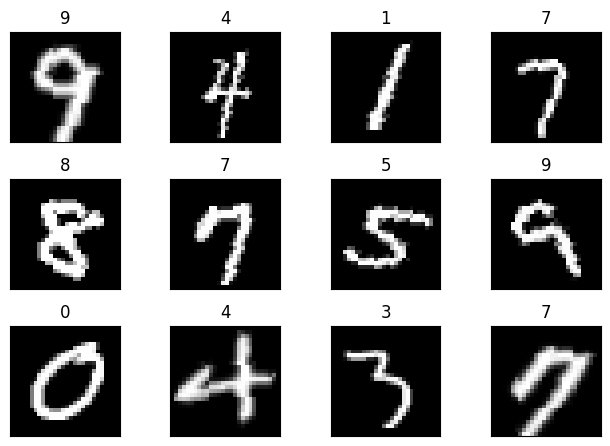

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='valid')
        self.batch_norm=nn.BatchNorm2d(32)
        self.batch_norm_n=nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.7)
        self.fc1 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.conv1(x)#28*28>26*26
        x = F.relu(x)
        x=  self.batch_norm(x)
        x = F.avg_pool2d(x,2)#26*26>13*13
        x = self.conv2(x)#13*13>11*11
        x = F.relu(x)
        x=  self.batch_norm_n(x)
        #x = F.relu(x)
        x = F.avg_pool2d(x,2)#11*11>6*6
        x = self.dropout1(x)
        #x = torch.nn.AvgPool2d(kernel_size = 6, stride = 0, padding = 0, ceil_mode=False, count_include_pad=True)
        #x=F.avg_pool2d(x,6)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        output = F.softmax(x, dim=1)
        return output

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 64, 11, 11]          18,496
       BatchNorm2d-4           [-1, 64, 11, 11]             128
           Dropout-5             [-1, 64, 5, 5]               0
            Linear-6                   [-1, 10]             650
Total params: 19,658
Trainable params: 19,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.07
Estimated Total Size (MB): 0.54
----------------------------------------------------------------


CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=-0.5308 Batch_id=234 Accuracy=37.48: 100%|██████████| 235/235 [01:38<00:00,  2.39it/s]


Test set: Average loss: -0.6011, Accuracy: 6648/10000 (66.48%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2


Train: Loss=-0.8655 Batch_id=234 Accuracy=81.22: 100%|██████████| 235/235 [01:26<00:00,  2.70it/s]


Test set: Average loss: -0.8853, Accuracy: 9249/10000 (92.49%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3


Train: Loss=-0.8512 Batch_id=234 Accuracy=91.22: 100%|██████████| 235/235 [01:27<00:00,  2.69it/s]


Test set: Average loss: -0.9347, Accuracy: 9586/10000 (95.86%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4


Train: Loss=-0.8929 Batch_id=234 Accuracy=92.41: 100%|██████████| 235/235 [01:26<00:00,  2.70it/s]


Test set: Average loss: -0.9527, Accuracy: 9655/10000 (96.55%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5


Train: Loss=-0.8930 Batch_id=234 Accuracy=93.22: 100%|██████████| 235/235 [01:26<00:00,  2.71it/s]


Test set: Average loss: -0.9430, Accuracy: 9576/10000 (95.76%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6


Train: Loss=-0.9133 Batch_id=234 Accuracy=93.60: 100%|██████████| 235/235 [01:28<00:00,  2.65it/s]


Test set: Average loss: -0.9659, Accuracy: 9739/10000 (97.39%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7


Train: Loss=-0.9054 Batch_id=234 Accuracy=94.14: 100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Test set: Average loss: -0.9566, Accuracy: 9650/10000 (96.50%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8


Train: Loss=-0.9596 Batch_id=234 Accuracy=94.30: 100%|██████████| 235/235 [01:32<00:00,  2.54it/s]


Test set: Average loss: -0.9591, Accuracy: 9667/10000 (96.67%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9


Train: Loss=-0.8776 Batch_id=234 Accuracy=94.44: 100%|██████████| 235/235 [01:32<00:00,  2.55it/s]


Test set: Average loss: -0.9713, Accuracy: 9765/10000 (97.65%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10


Train: Loss=-0.9501 Batch_id=234 Accuracy=94.48: 100%|██████████| 235/235 [01:30<00:00,  2.61it/s]


Test set: Average loss: -0.9737, Accuracy: 9790/10000 (97.90%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 11


Train: Loss=-0.9377 Batch_id=234 Accuracy=94.58: 100%|██████████| 235/235 [01:29<00:00,  2.63it/s]


Test set: Average loss: -0.9726, Accuracy: 9775/10000 (97.75%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 12


Train: Loss=-0.9067 Batch_id=234 Accuracy=94.74: 100%|██████████| 235/235 [01:25<00:00,  2.76it/s]


Test set: Average loss: -0.9629, Accuracy: 9691/10000 (96.91%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 13


Train: Loss=-0.9119 Batch_id=234 Accuracy=94.85: 100%|██████████| 235/235 [01:22<00:00,  2.83it/s]


Test set: Average loss: -0.9547, Accuracy: 9604/10000 (96.04%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 14


Train: Loss=-0.9128 Batch_id=234 Accuracy=95.03: 100%|██████████| 235/235 [01:21<00:00,  2.89it/s]


Test set: Average loss: -0.9760, Accuracy: 9805/10000 (98.05%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 15


Train: Loss=-0.9868 Batch_id=234 Accuracy=94.93: 100%|██████████| 235/235 [01:22<00:00,  2.84it/s]


Test set: Average loss: -0.9751, Accuracy: 9778/10000 (97.78%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 16


Train: Loss=-0.9616 Batch_id=234 Accuracy=95.39: 100%|██████████| 235/235 [01:23<00:00,  2.80it/s]


Test set: Average loss: -0.9796, Accuracy: 9824/10000 (98.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 17


Train: Loss=-0.9673 Batch_id=234 Accuracy=95.51: 100%|██████████| 235/235 [01:23<00:00,  2.80it/s]


Test set: Average loss: -0.9798, Accuracy: 9825/10000 (98.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 18


Train: Loss=-0.9172 Batch_id=234 Accuracy=95.59: 100%|██████████| 235/235 [01:22<00:00,  2.84it/s]


Test set: Average loss: -0.9799, Accuracy: 9829/10000 (98.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 19


Train: Loss=-0.9498 Batch_id=234 Accuracy=95.56: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Test set: Average loss: -0.9798, Accuracy: 9820/10000 (98.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 20


Train: Loss=-0.9425 Batch_id=234 Accuracy=95.72: 100%|██████████| 235/235 [01:24<00:00,  2.78it/s]


Test set: Average loss: -0.9803, Accuracy: 9836/10000 (98.36%)

Adjusting learning rate of group 0 to 1.0000e-02.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

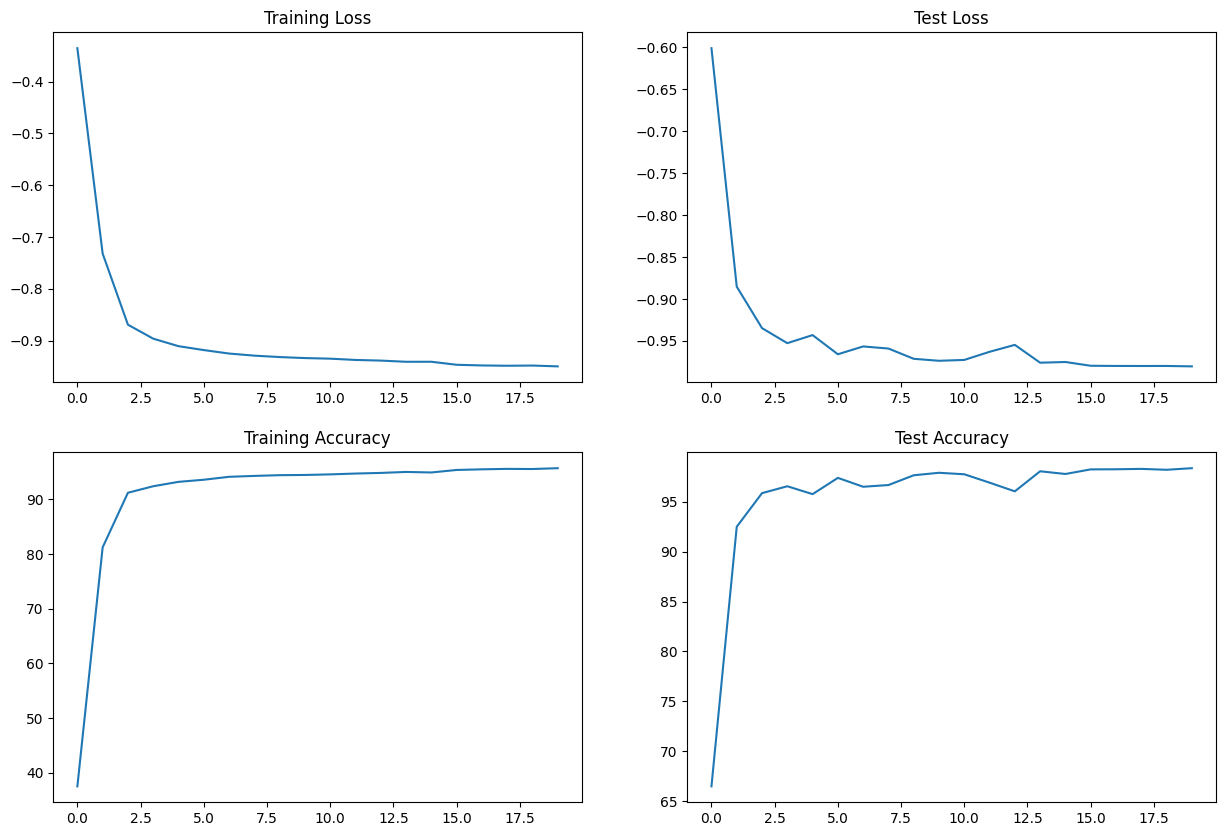

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 64, 11, 11]          18,496
       BatchNorm2d-4           [-1, 64, 11, 11]             128
           Dropout-5             [-1, 64, 5, 5]               0
            Linear-6                   [-1, 10]             650
Total params: 19,658
Trainable params: 19,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.07
Estimated Total Size (MB): 0.54
----------------------------------------------------------------
